In [1]:
import numpy as np
import pandas as pd

import os
import io

import pickle # saving and loading trained model
from os import path

import matplotlib.pyplot as plt

import seaborn as sns

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
import missingno as msgno # for analysing missing values

from keras.models import Sequential
from keras import callbacks
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D, LSTM, RepeatVector, TimeDistributed, Input
from tensorflow.keras import Model
from sklearn import metrics

from tensorflow import keras

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import datetime as dt
import seaborn as sn



2024-11-19 22:06:10.151020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Loading dataset
dataDir = './data'
csvfiles = os.listdir(dataDir)
df = pd.DataFrame()

dFrames = []

#iterate through all the files, read it and combine the data
for fname in csvfiles:
    if(fname.split(".")[1] == 'csv'):
        df = pd.read_csv(os.path.join(dataDir, fname), low_memory=False, index_col=None, header=0)
        dFrames.append(df)
        print("Read file {}".format(fname))

df = pd.concat(dFrames, axis=0, ignore_index=True)

print("Finisehd loading files")

Read file metasploitable-2.csv
Read file Normal_data.csv
Read file OVS.csv
Finisehd loading files


In [3]:
#Take a quick look at the data
df.head() # quick look at the data

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.3.130-200.175.2.130-38694-4444-6,192.168.3.130,38694,200.175.2.130,4444,6,10/1/2020 5:02,269709,4,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U2R
1,192.168.3.130-200.175.2.130-38693-4444-6,192.168.3.130,38693,200.175.2.130,4444,6,10/1/2020 5:02,268599,2,3,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U2R
2,192.168.3.130-200.175.2.130-3632-33747-6,200.175.2.130,33747,192.168.3.130,3632,6,10/1/2020 5:02,22194,5,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U2R
3,192.168.3.130-200.175.2.130-8180-38745-6,200.175.2.130,38745,192.168.3.130,8180,6,10/1/2020 1:39,9556,4,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
4,192.168.3.130-200.175.2.130-8180-37217-6,200.175.2.130,37217,192.168.3.130,8180,6,10/1/2020 1:39,8782,4,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA


In [4]:
# Get an idea about number of columns & rows
df.shape

(343889, 84)

343889 records each with 84 columns/attributes including the Label column

In [5]:
#Get an idea about datatypes of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343889 entries, 0 to 343888
Data columns (total 84 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Flow ID            343889 non-null  object 
 1   Src IP             343889 non-null  object 
 2   Src Port           343889 non-null  int64  
 3   Dst IP             343889 non-null  object 
 4   Dst Port           343889 non-null  int64  
 5   Protocol           343889 non-null  int64  
 6   Timestamp          343889 non-null  object 
 7   Flow Duration      343889 non-null  int64  
 8   Tot Fwd Pkts       343889 non-null  int64  
 9   Tot Bwd Pkts       343889 non-null  int64  
 10  TotLen Fwd Pkts    343889 non-null  float64
 11  TotLen Bwd Pkts    343889 non-null  float64
 12  Fwd Pkt Len Max    343889 non-null  int64  
 13  Fwd Pkt Len Min    343889 non-null  int64  
 14  Fwd Pkt Len Mean   343889 non-null  float64
 15  Fwd Pkt Len Std    343889 non-null  float64
 16  Bw

Most of the attributes are numeric in type excpet the IPs, timestamp, flowID & Label

In [6]:
# Get an idea about the distribution/statistics of data
df.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,343889.000000,343889.000000,343889.000000,3.438890e+05,343889.000000,343889.000000,3.438890e+05,3.438890e+05,343889.000000,343889.000000,...,343889.000000,343889.0,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05
mean,21982.659541,8072.495366,4.961767,6.737171e+06,6.160331,6.119012,7.310557e+02,8.335005e+03,115.689356,4.447778,...,1.441541,0.0,6.385104e+04,3.105350e+04,1.086384e+05,4.185579e+04,4.708172e+06,1.443613e+05,4.843965e+06,4.581512e+06
std,23669.464108,16275.407358,4.862608,2.183354e+07,1554.168988,105.863392,6.965289e+04,3.429719e+05,666.519811,31.285832,...,39.470056,0.0,7.852718e+05,5.035601e+05,1.220601e+06,6.672299e+05,1.616113e+07,1.653491e+06,1.641612e+07,1.604560e+07
min,0.000000,0.000000,0.000000,-1.540000e+02,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,1.700000e+01,0.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,443.000000,80.000000,6.000000,2.530000e+03,0.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,43920.000000,2495.000000,6.000000,1.208600e+04,2.000000,4.000000,3.000000e+01,3.000000e+01,30.000000,0.000000,...,1.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65518.000000,65389.000000,17.000000,1.200000e+08,910748.000000,34094.000000,3.160000e+07,1.070000e+08,64239.000000,3900.000000,...,11180.000000,0.0,1.040000e+08,6.830000e+07,1.040000e+08,1.040000e+08,1.200000e+08,7.300000e+07,1.200000e+08,1.200000e+08


In [7]:
#check for null values in the columns
df.isnull().sum()

Flow ID      0
Src IP       0
Src Port     0
Dst IP       0
Dst Port     0
            ..
Idle Mean    0
Idle Std     0
Idle Max     0
Idle Min     0
Label        0
Length: 84, dtype: int64

No Null values found in the dataset

<AxesSubplot: >

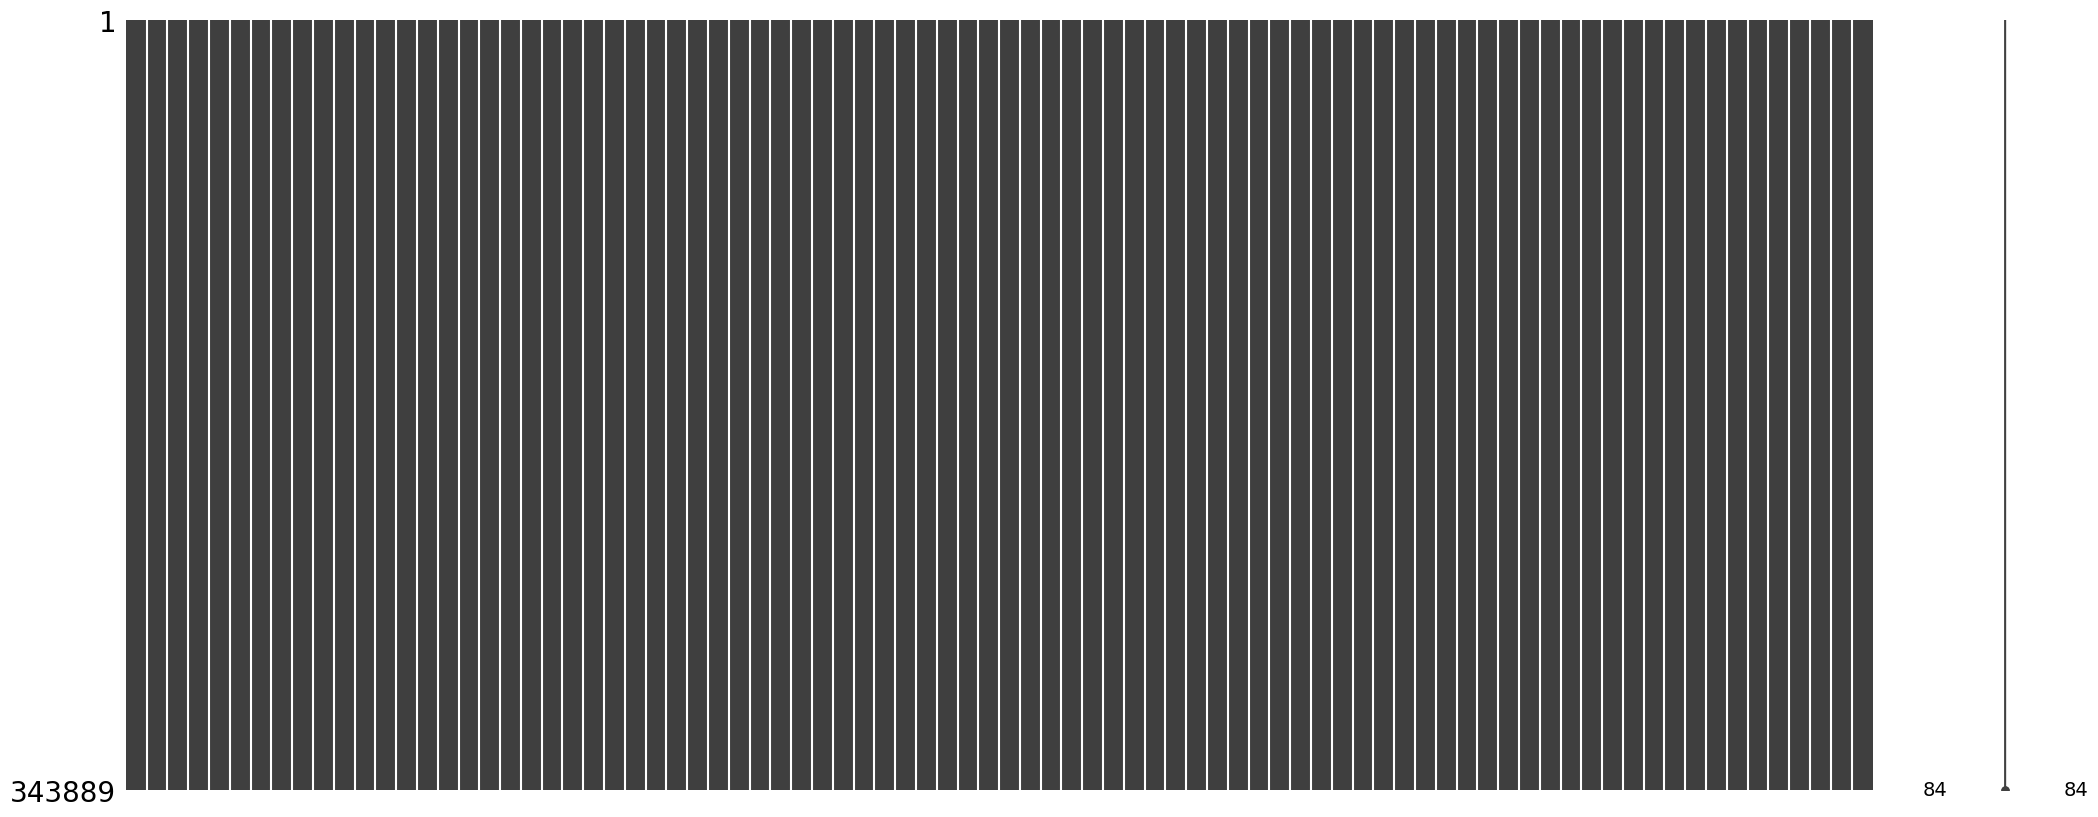

In [8]:
# find for missing values
msgno.matrix(df) 

In [9]:
#check for null values in the columns
pd.set_option('display.max_rows', None)
((df == 0).sum()).sort_values()
pd.set_option('display.max_rows', 10)

In [10]:
#Check for duplicate values
#df[df.duplicated()]
#deduplicate
df.drop_duplicates(keep='first', inplace = True)

Though there are no null values, there are many columns with all 0 zero values. Lets remove those columns

In [11]:
#Drop columns with all zero values
allZeroColumns = ['Bwd Pkts/b Avg','Bwd Byts/b Avg','Fwd Blk Rate Avg','Fwd Seg Size Min','Fwd Pkts/b Avg', 'Fwd Byts/b Avg', 'Fwd URG Flags', 'ECE Flag Cnt', 'CWE Flag Count', 'Fwd PSH Flags', 'Bwd Blk Rate Avg','Init Fwd Win Byts']
df.drop(labels=allZeroColumns, axis='columns', inplace=True)

#Drop other non numeric columns
objColumns = ['Flow ID', 'Timestamp', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port']
df.drop(labels=objColumns, axis='columns', inplace=True)

In [12]:
df.shape

(343888, 66)

In [13]:
df['Label'].unique()

array(['U2R', 'BFA', 'DDoS', 'DoS', 'Probe', 'Normal', 'DDoS ',
       'Web-Attack', 'BOTNET'], dtype=object)

DDoS is listed twice, one with space and one without. This needs to be fixed to represent uniquely

In [14]:
df.loc[df['Label'] == 'DDoS ', 'Label'] = 'DDoS'

In [15]:
#inspecting the dataset after updation
df['Label'].unique()

array(['U2R', 'BFA', 'DDoS', 'DoS', 'Probe', 'Normal', 'Web-Attack',
       'BOTNET'], dtype=object)

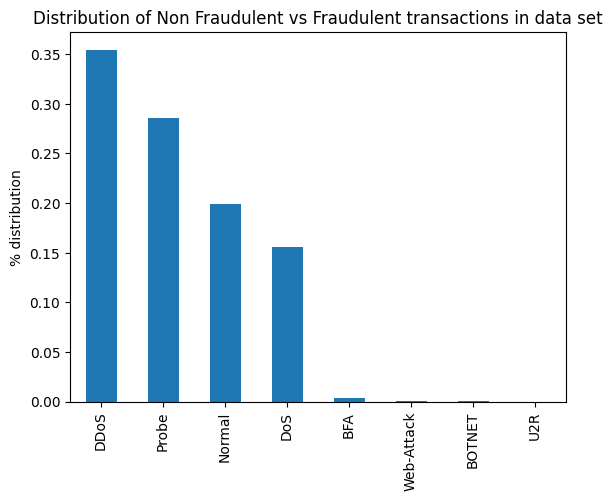

In [16]:
#Visualizing the distribution of type of attacks and normal data
gph = df['Label'].value_counts(normalize = True).plot.bar()
plt.title('Distribution of Non Fraudulent vs Fraudulent transactions in data set')
plt.ylabel('% distribution')
plt.show()


In [17]:
df['Label'].value_counts()

DDoS          121942
Probe          98129
Normal         68423
DoS            53616
BFA             1405
Web-Attack       192
BOTNET           164
U2R               17
Name: Label, dtype: int64

Data showing DDoS attack is the heighest in the dataset with 121942 records which is even higher than the normal samples(68424). Records representing U2R, BOTNET and Web-Attack are very less in number.

The whole dataset contains one duplicate. Remove the duplicate record before proceeding further

In [18]:
df.shape

(343888, 66)

In [19]:
df.corr()

/var/folders/dt/9p_fdpvn1lz7gcclv_4_v6780000gp/T/ipykernel_43818/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Init Bwd Win Byts,Fwd Act Data Pkts,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Protocol,1.000000,0.066234,-0.000650,0.009640,0.002751,0.005546,0.050929,0.325122,0.069282,0.032514,...,0.067594,0.033377,0.022079,0.014472,0.022453,0.018246,0.068891,0.023330,0.069937,0.067360
Flow Duration,0.066234,1.000000,0.009232,0.102009,0.025915,0.071415,0.157387,-0.035240,0.055153,0.088872,...,0.324433,0.067988,0.218850,0.253573,0.301179,0.122111,0.839685,0.318060,0.857776,0.815867
Tot Fwd Pkts,-0.000650,0.009232,1.000000,0.030547,0.016473,0.026117,0.003402,-0.000217,0.001109,0.000872,...,0.003633,0.025992,0.007654,0.006776,0.008954,0.005323,0.000501,0.002168,0.000735,0.000300
Tot Bwd Pkts,0.009640,0.102009,0.030547,1.000000,0.331990,0.901666,0.098560,-0.004658,0.032700,0.026759,...,0.093684,0.239669,0.100922,0.149906,0.156382,0.037760,0.019326,0.045823,0.024115,0.015085
TotLen Fwd Pkts,0.002751,0.025915,0.016473,0.331990,1.000000,0.004207,0.112187,-0.000156,0.071771,0.038039,...,0.024372,0.635187,0.057057,0.075228,0.074036,0.028689,0.002573,0.012051,0.003842,0.001414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Active Min,0.018246,0.122111,0.005323,0.037760,0.028689,0.014887,0.050135,-0.004266,0.032409,0.028746,...,0.099292,0.177615,0.884671,0.071404,0.597926,1.000000,0.048066,0.160527,0.063045,0.034780
Idle Mean,0.068891,0.839685,0.000501,0.019326,0.002573,0.005693,0.072662,-0.036175,0.023448,0.048695,...,0.103553,0.017278,0.061589,0.045635,0.061180,0.048066,1.000000,0.126525,0.995621,0.996572
Idle Std,0.023330,0.318060,0.002168,0.045823,0.012051,0.024242,0.109577,-0.006770,0.041785,0.053469,...,0.234272,0.040868,0.239795,0.223144,0.263904,0.160527,0.126525,1.000000,0.214422,0.046146
Idle Max,0.069937,0.857776,0.000735,0.024115,0.003842,0.008158,0.083028,-0.036260,0.027340,0.053323,...,0.123899,0.021595,0.085080,0.068776,0.088729,0.063045,0.995621,0.214422,1.000000,0.984972


/var/folders/dt/9p_fdpvn1lz7gcclv_4_v6780000gp/T/ipykernel_43818/1984464735.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  crmat = df.corr()


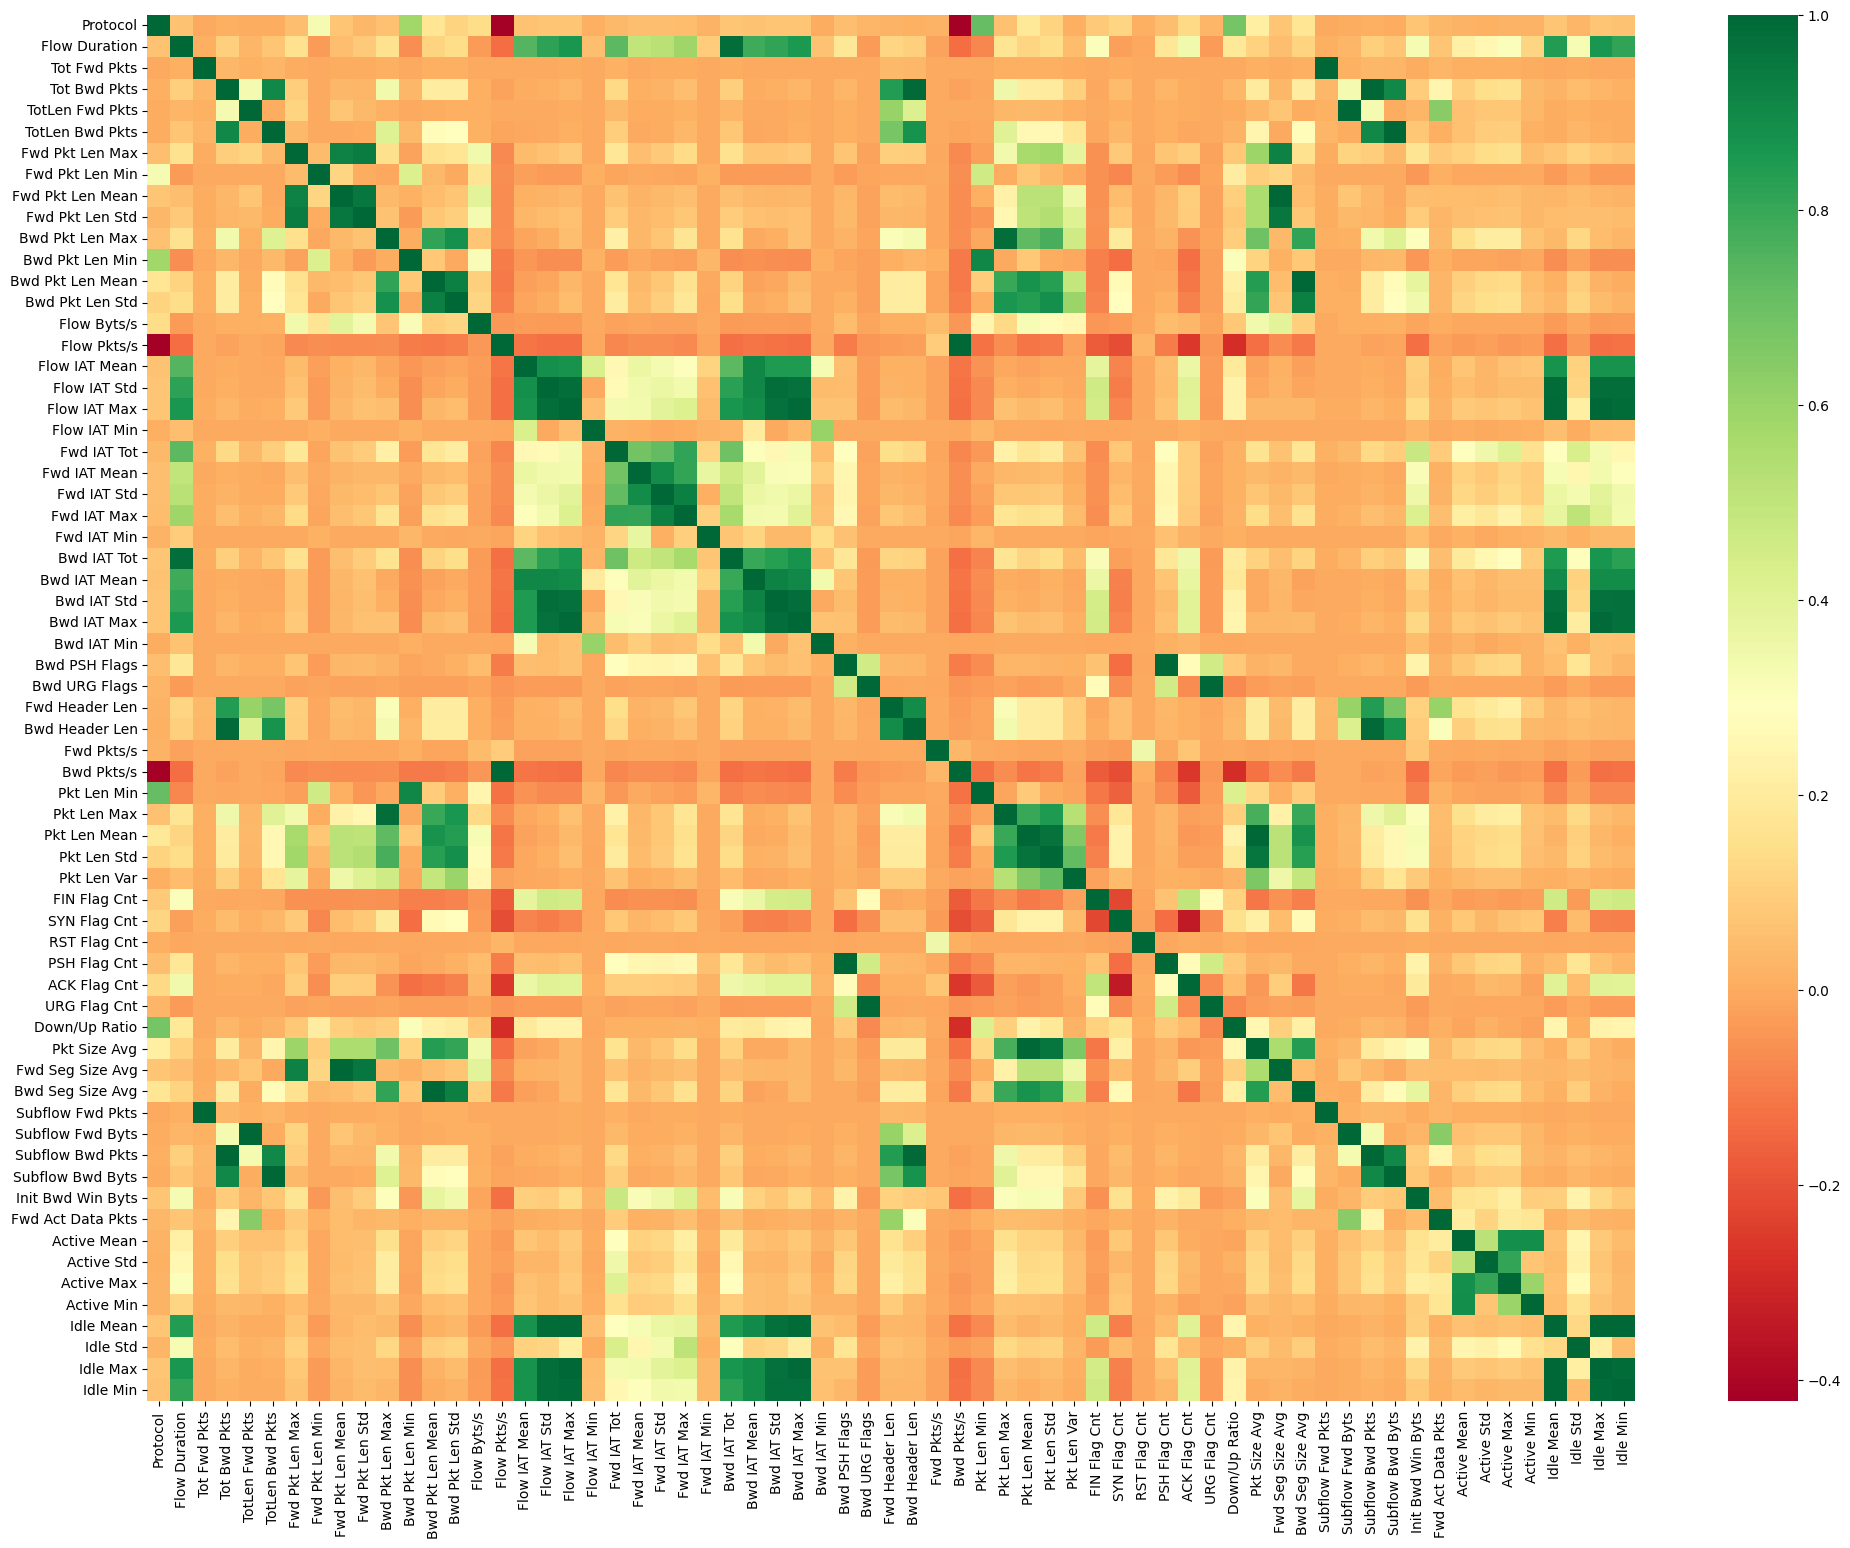

In [20]:
crmat = df.corr()
plt.figure(figsize=(24,18))
sns.heatmap(crmat, cmap="RdYlGn", annot=False)
plt.show()

Above heat map is very difficult to analyze, hence avoiding multiple statitics present for the same metrics in the dataset and plotting a new heatmap

/var/folders/dt/9p_fdpvn1lz7gcclv_4_v6780000gp/T/ipykernel_43818/4063061794.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  crmat = dfCorr.corr()


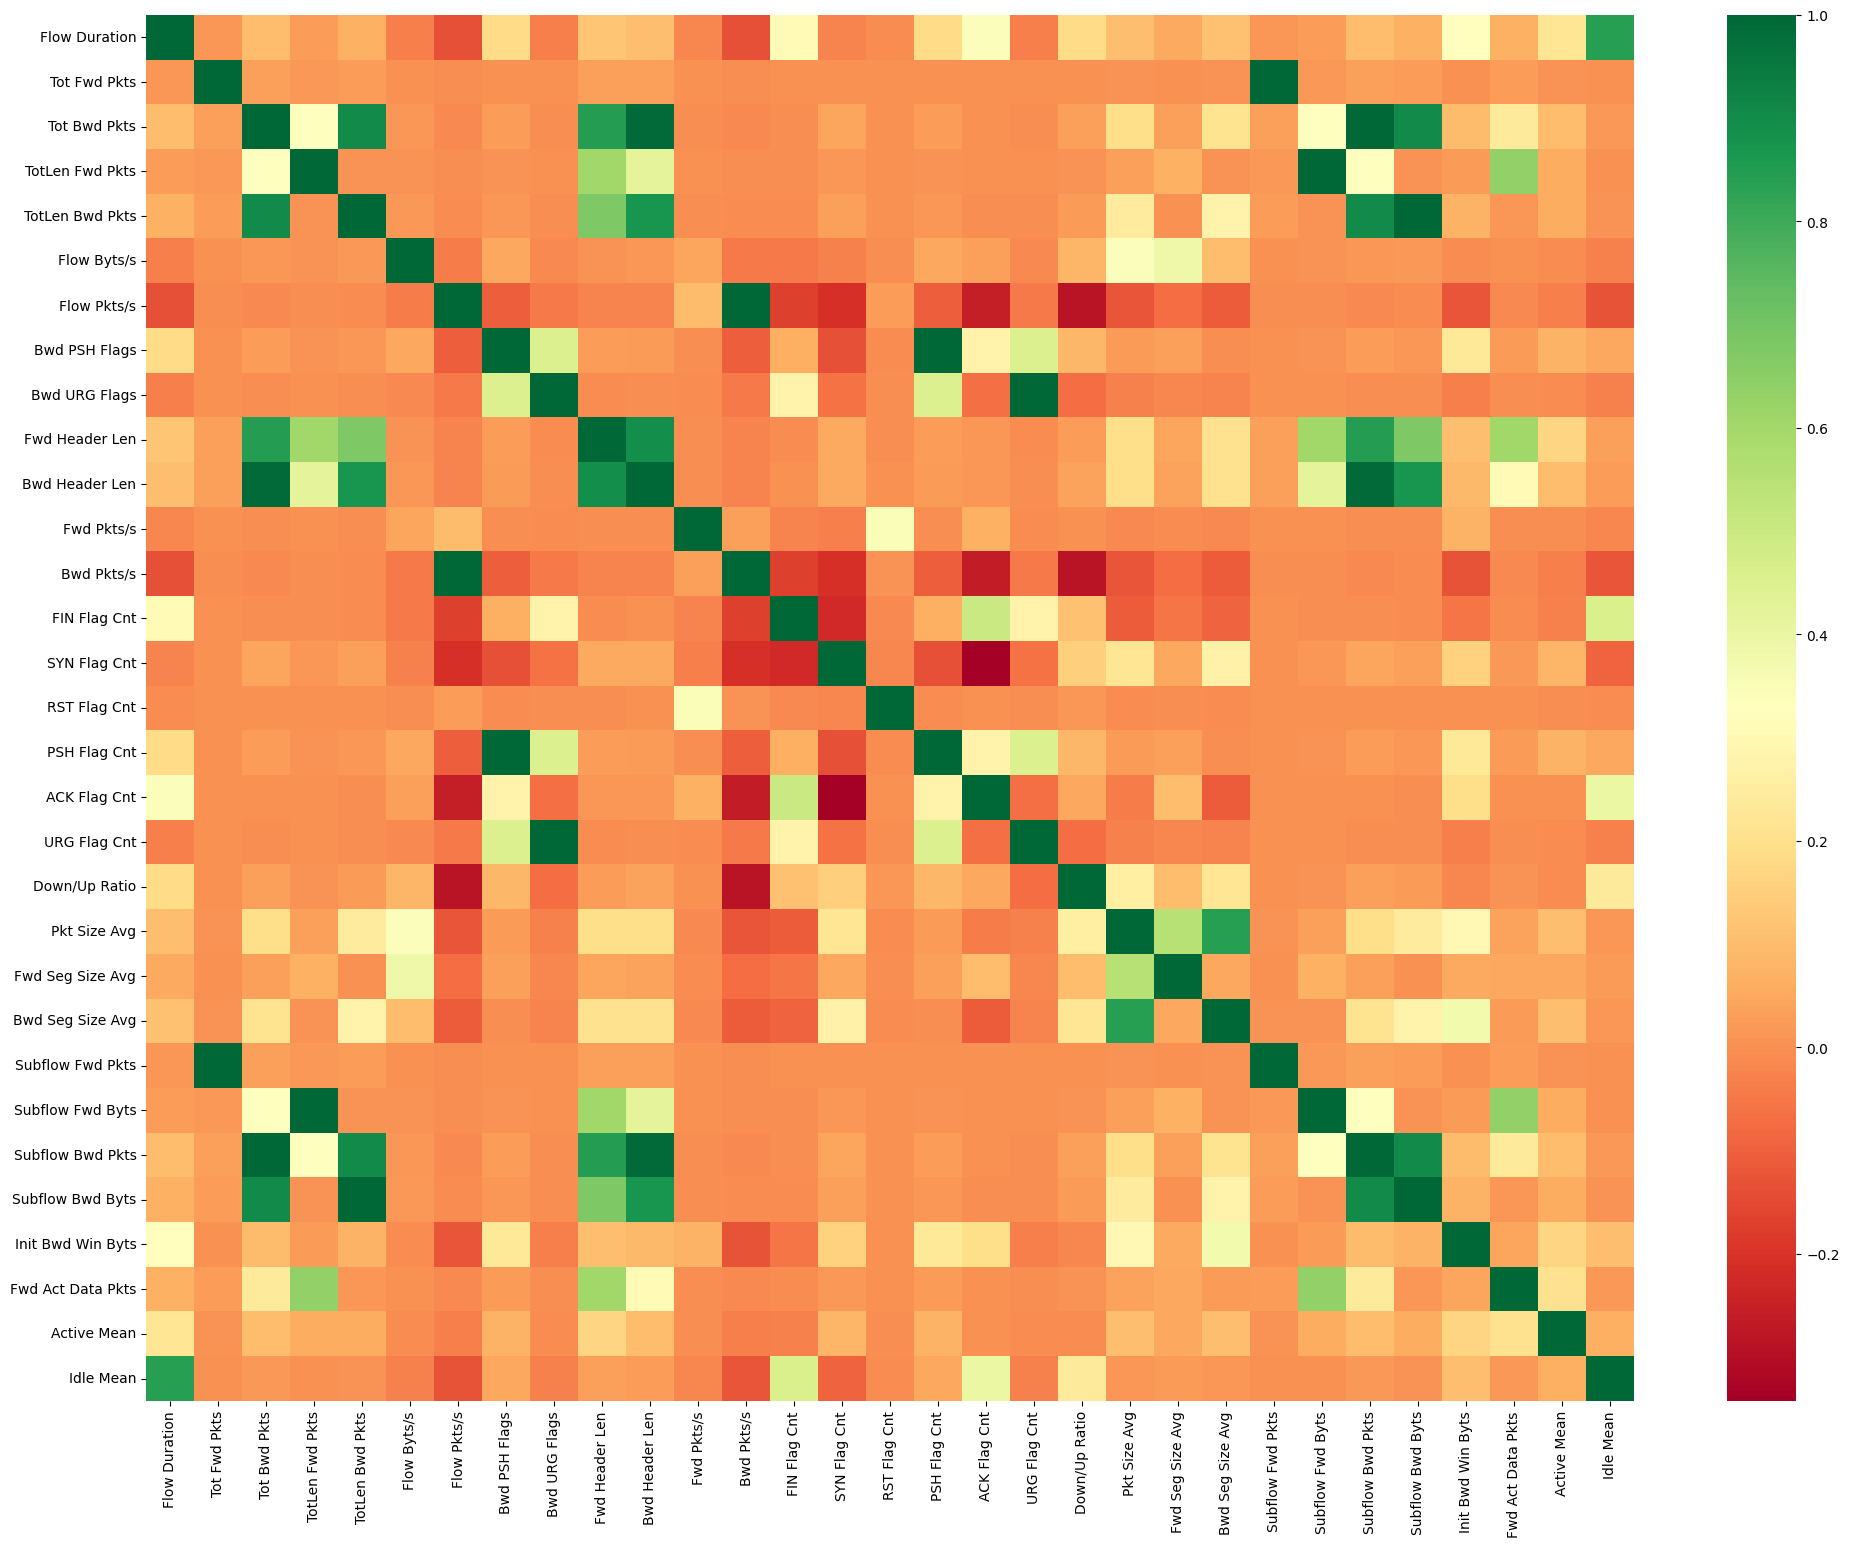

In [21]:
pd.set_option('display.max_rows', 10)
dfCorr = df[['Flow Duration','Tot Fwd Pkts','Tot Bwd Pkts','TotLen Fwd Pkts','TotLen Bwd Pkts','Flow Byts/s','Flow Pkts/s','Bwd PSH Flags','Bwd URG Flags','Fwd Header Len','Bwd Header Len','Fwd Pkts/s','Bwd Pkts/s','FIN Flag Cnt','SYN Flag Cnt','RST Flag Cnt','PSH Flag Cnt','ACK Flag Cnt','URG Flag Cnt','Down/Up Ratio','Pkt Size Avg','Fwd Seg Size Avg','Bwd Seg Size Avg','Subflow Fwd Pkts','Subflow Fwd Byts','Subflow Bwd Pkts','Subflow Bwd Byts','Init Bwd Win Byts','Fwd Act Data Pkts','Active Mean','Idle Mean','Label']]
crmat = dfCorr.corr()
plt.figure(figsize=(24,18))
sns.heatmap(crmat, cmap="RdYlGn", annot=False)
plt.show()

In [22]:
#drop na values and reset index
reIdxdf = df.dropna().reset_index()

# label encoding
labelencoder = LabelEncoder()
reIdxdf['Label'] = labelencoder.fit_transform(reIdxdf['Label'])

reIdxdf['Label'].value_counts()

data_np = reIdxdf.to_numpy(dtype="float32")
data_np = data_np[~np.isinf(data_np).any(axis=1)]

In [23]:
X = data_np[:, 0:65]

enc = OneHotEncoder()
Y = enc.fit_transform(data_np[:,66:]).toarray()

In [24]:
X.shape

(343888, 65)

In [25]:
Y.shape

(343888, 8)

In [26]:
#test train split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=2, shuffle=True)

_features = X.shape[1]
n_classes = Y.shape[1]

## Simple Neural Network

In [27]:
#Build simple Neural Network
modelDnn = Sequential()
modelDnn.add(Dense(128, input_dim=_features, activation='relu'))
modelDnn.add(Dropout(0.1))
modelDnn.add(Dense(256, activation='relu'))
modelDnn.add(Dropout(0.1))
modelDnn.add(Dense(128, activation='relu'))
modelDnn.add(Dropout(0.1))
modelDnn.add(Dense(96, kernel_initializer='normal'))
modelDnn.add(Dense(n_classes, activation = 'sigmoid'))
modelDnn.summary() 

opt = keras.optimizers.Adam(learning_rate=0.0001)
modelDnn.compile(loss='BinaryCrossentropy', optimizer=opt, metrics=['accuracy'])

early_stop_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=3, min_lr=0.001)
    
history = modelDnn.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=30,
                              verbose=True, #,callbacks=[reduce_lr, early_stop_callback],
                              validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8448      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 96)                1

In [28]:
def predictAndPlot(model, X_test, Y_test):
    start = dt.datetime.now()

    escore = model.evaluate(X_test, Y_test, batch_size=32)
    pred = model.predict(X_test)
    pred = np.argmax(pred,axis=1)
    y_eval = np.argmax(Y_test,axis=1)   

    score = metrics.accuracy_score(y_eval, pred)
    rscore = recall_score(y_eval, pred, average='weighted')
    ascore = precision_score(y_eval, pred, average='weighted')
    f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

    lb = preprocessing.LabelBinarizer()
    lb.fit(y_eval)
    y_eval = lb.transform(y_eval)
    pred = lb.transform(pred)
    roc_score = roc_auc_score(y_eval, pred)
    #roc_auc_socre = multiclass_roc_auc_score(y_eval, pred)

    print('Printing Summary')
    print('===================================')    
    print('Time taken:',dt.datetime.now()-start)
    print("Validation score: {}".format(score))
    print("Evaluation score: {}".format(escore))
    print("Recall score: {}".format(rscore))
    print("Precision score: {}".format(ascore))
    print("F1 Measure score: {}".format(f1score))
    print("ROC-AUC score: {}".format(roc_score))
    
    #Now plot
    pred = np.argmax(pred,axis=1)
    y_test = Y_test.argmax(axis=1)
    confMat = confusion_matrix(y_test, pred)
    cm_df = pd.DataFrame(confMat)

    labels = ['DDoS', 'Probe', 'Normal', 'DoS', 'BFA', 'Web-Attack', 'BOTNET', 'U2R']
    sn.set(rc = {'figure.figsize':(15,10)})
    sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')

    plt.show()  

In [29]:
modelDnn.save('./models/dnn2Model.h5')

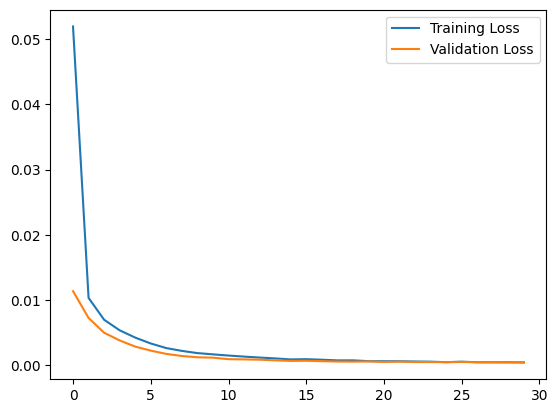

In [30]:
# training history visualization
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

2687/2687 [==============================] - 4s 1ms/step


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Printing Summary
Time taken: 0:00:11.179742
Validation score: 0.9995812590145629
Evaluation score: [0.00046713175834156573, 0.9995812773704529]
Recall score: 0.9995812590145629
Precision score: 0.9995850882924783
F1 Measure score: 0.9995563580651877
ROC-AUC score: 0.915429626098213


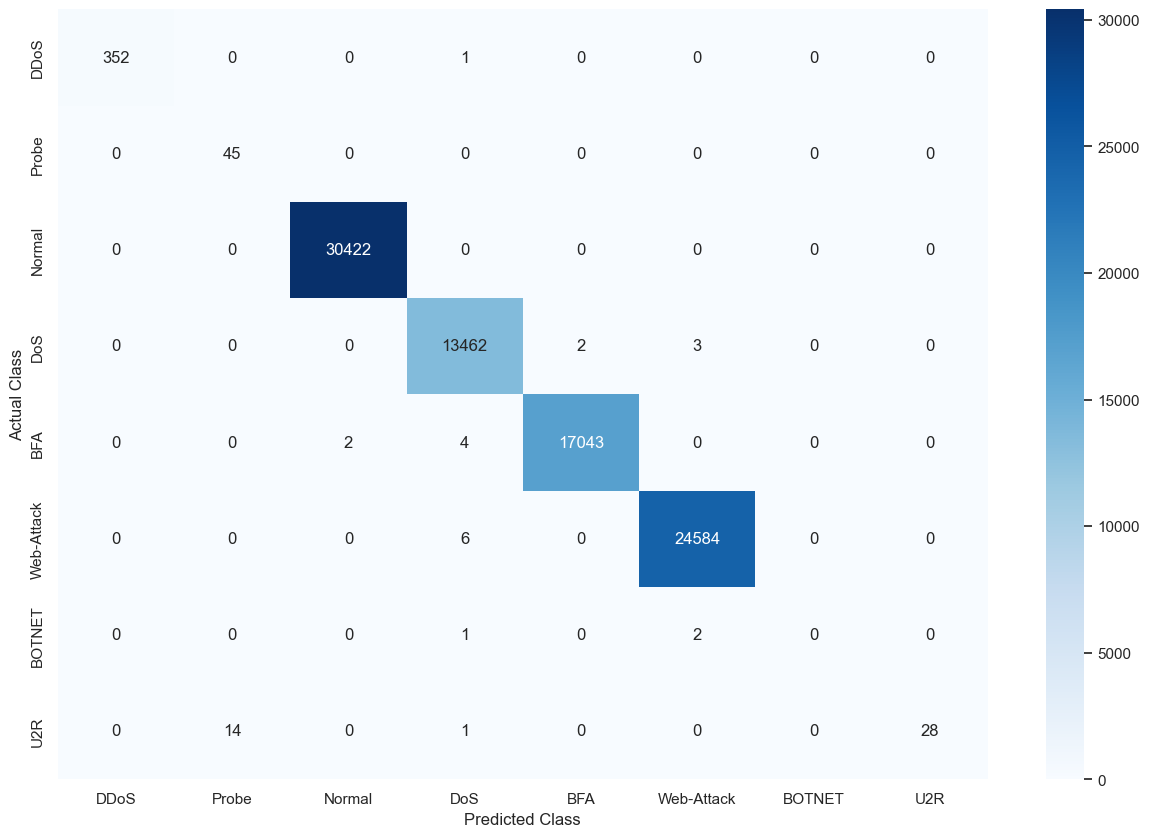

In [31]:
predictAndPlot(modelDnn, X_test, Y_test)